In [1]:
from itertools import islice

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import pandas as pd
from sklearn.manifold import TSNE

In [3]:
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from pytorch_lightning.loggers import CSVLogger
from datasets import load_dataset

from estimator import NSTransformerEstimator

2022-11-15 16:57:16.475413: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
dataset = get_dataset("traffic")

In [6]:
estimator = NSTransformerEstimator(
        freq=dataset.metadata.freq,
        prediction_length=dataset.metadata.prediction_length,
        context_length=dataset.metadata.prediction_length*6,
        
        num_feat_static_cat=len(dataset.metadata.feat_static_cat),
        cardinality=[int(cat_feat_info.cardinality) for cat_feat_info in dataset.metadata.feat_static_cat],
        embedding_dimension=[2],
        
        nhead=2,
        num_encoder_layers=4,
        num_decoder_layers=2,
        dim_feedforward=16,
        activation="gelu",
        
        batch_size=256,
        num_batches_per_epoch=100,
        trainer_kwargs=dict(gpus="1", max_epochs=50, logger=CSVLogger(".", "lightning_logs/")),
    )

In [7]:
predictor = estimator.train(
        training_data=dataset.train,
        shuffle_buffer_length=1024,
        num_workers=8,
        cache_data=True,
    )

/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus='1')` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices='1')` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_ze

Training: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'train_loss' reached -2.78611 (best -2.78611), saving model to './lightning_logs/version_17/checkpoints/epoch=0-step=100.ckpt' as top 1
Epoch 1, global step 200: 'train_loss' reached -3.36287 (best -3.36287), saving model to './lightning_logs/version_17/checkpoints/epoch=1-step=200.ckpt' as top 1
Epoch 2, global step 300: 'train_loss' reached -3.53036 (best -3.53036), saving model to './lightning_logs/version_17/checkpoints/epoch=2-step=300.ckpt' as top 1
Epoch 3, global step 400: 'train_loss' reached -3.61337 (best -3.61337), saving model to './lightning_logs/version_17/checkpoints/epoch=3-step=400.ckpt' as top 1
Epoch 4, global step 500: 'train_loss' reached -3.67846 (best -3.67846), saving model to './lightning_logs/version_17/checkpoints/epoch=4-step=500.ckpt' as top 1
Epoch 5, global step 600: 'train_loss' reached -3.71343 (best -3.71343), saving model to './lightning_logs/version_17/checkpoints/epoch=5-step=600.ckpt' as top 1
Epoch 6, global step 700: 't

In [8]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
)

In [9]:
forecasts = list(forecast_it)

In [10]:
tss = list(ts_it)

In [11]:
evaluator = Evaluator()

In [12]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 6034it [00:00, 13806.78it/s]
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pandas/core/dtypes/astype.py:170: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [13]:
agg_metrics

{'MSE': 0.0005545510502650451,
 'abs_error': 1194.962294739671,
 'abs_target_sum': 8672.5710073933,
 'abs_target_mean': 0.0598868288545002,
 'seasonal_error': 0.015220711169889631,
 'MASE': 0.5268373852309536,
 'MAPE': 0.19698710231386743,
 'sMAPE': 0.14366331204023727,
 'MSIS': 6.645775867073212,
 'QuantileLoss[0.1]': 567.1987160773047,
 'Coverage[0.1]': 0.11960694950834162,
 'QuantileLoss[0.2]': 810.5378031823493,
 'Coverage[0.2]': 0.2525066291017567,
 'QuantileLoss[0.3]': 990.0108320649057,
 'Coverage[0.3]': 0.3814633742127942,
 'QuantileLoss[0.4]': 1117.429615440246,
 'Coverage[0.4]': 0.49868799027731747,
 'QuantileLoss[0.5]': 1194.9622953646176,
 'Coverage[0.5]': 0.6009695061319191,
 'QuantileLoss[0.6]': 1216.9032527409088,
 'Coverage[0.6]': 0.6836054027179317,
 'QuantileLoss[0.7]': 1180.0741097792227,
 'Coverage[0.7]': 0.7650121533532207,
 'QuantileLoss[0.8]': 1065.84677780545,
 'Coverage[0.8]': 0.8383880234228263,
 'QuantileLoss[0.9]': 831.3034810785131,
 'Coverage[0.9]': 0.9074

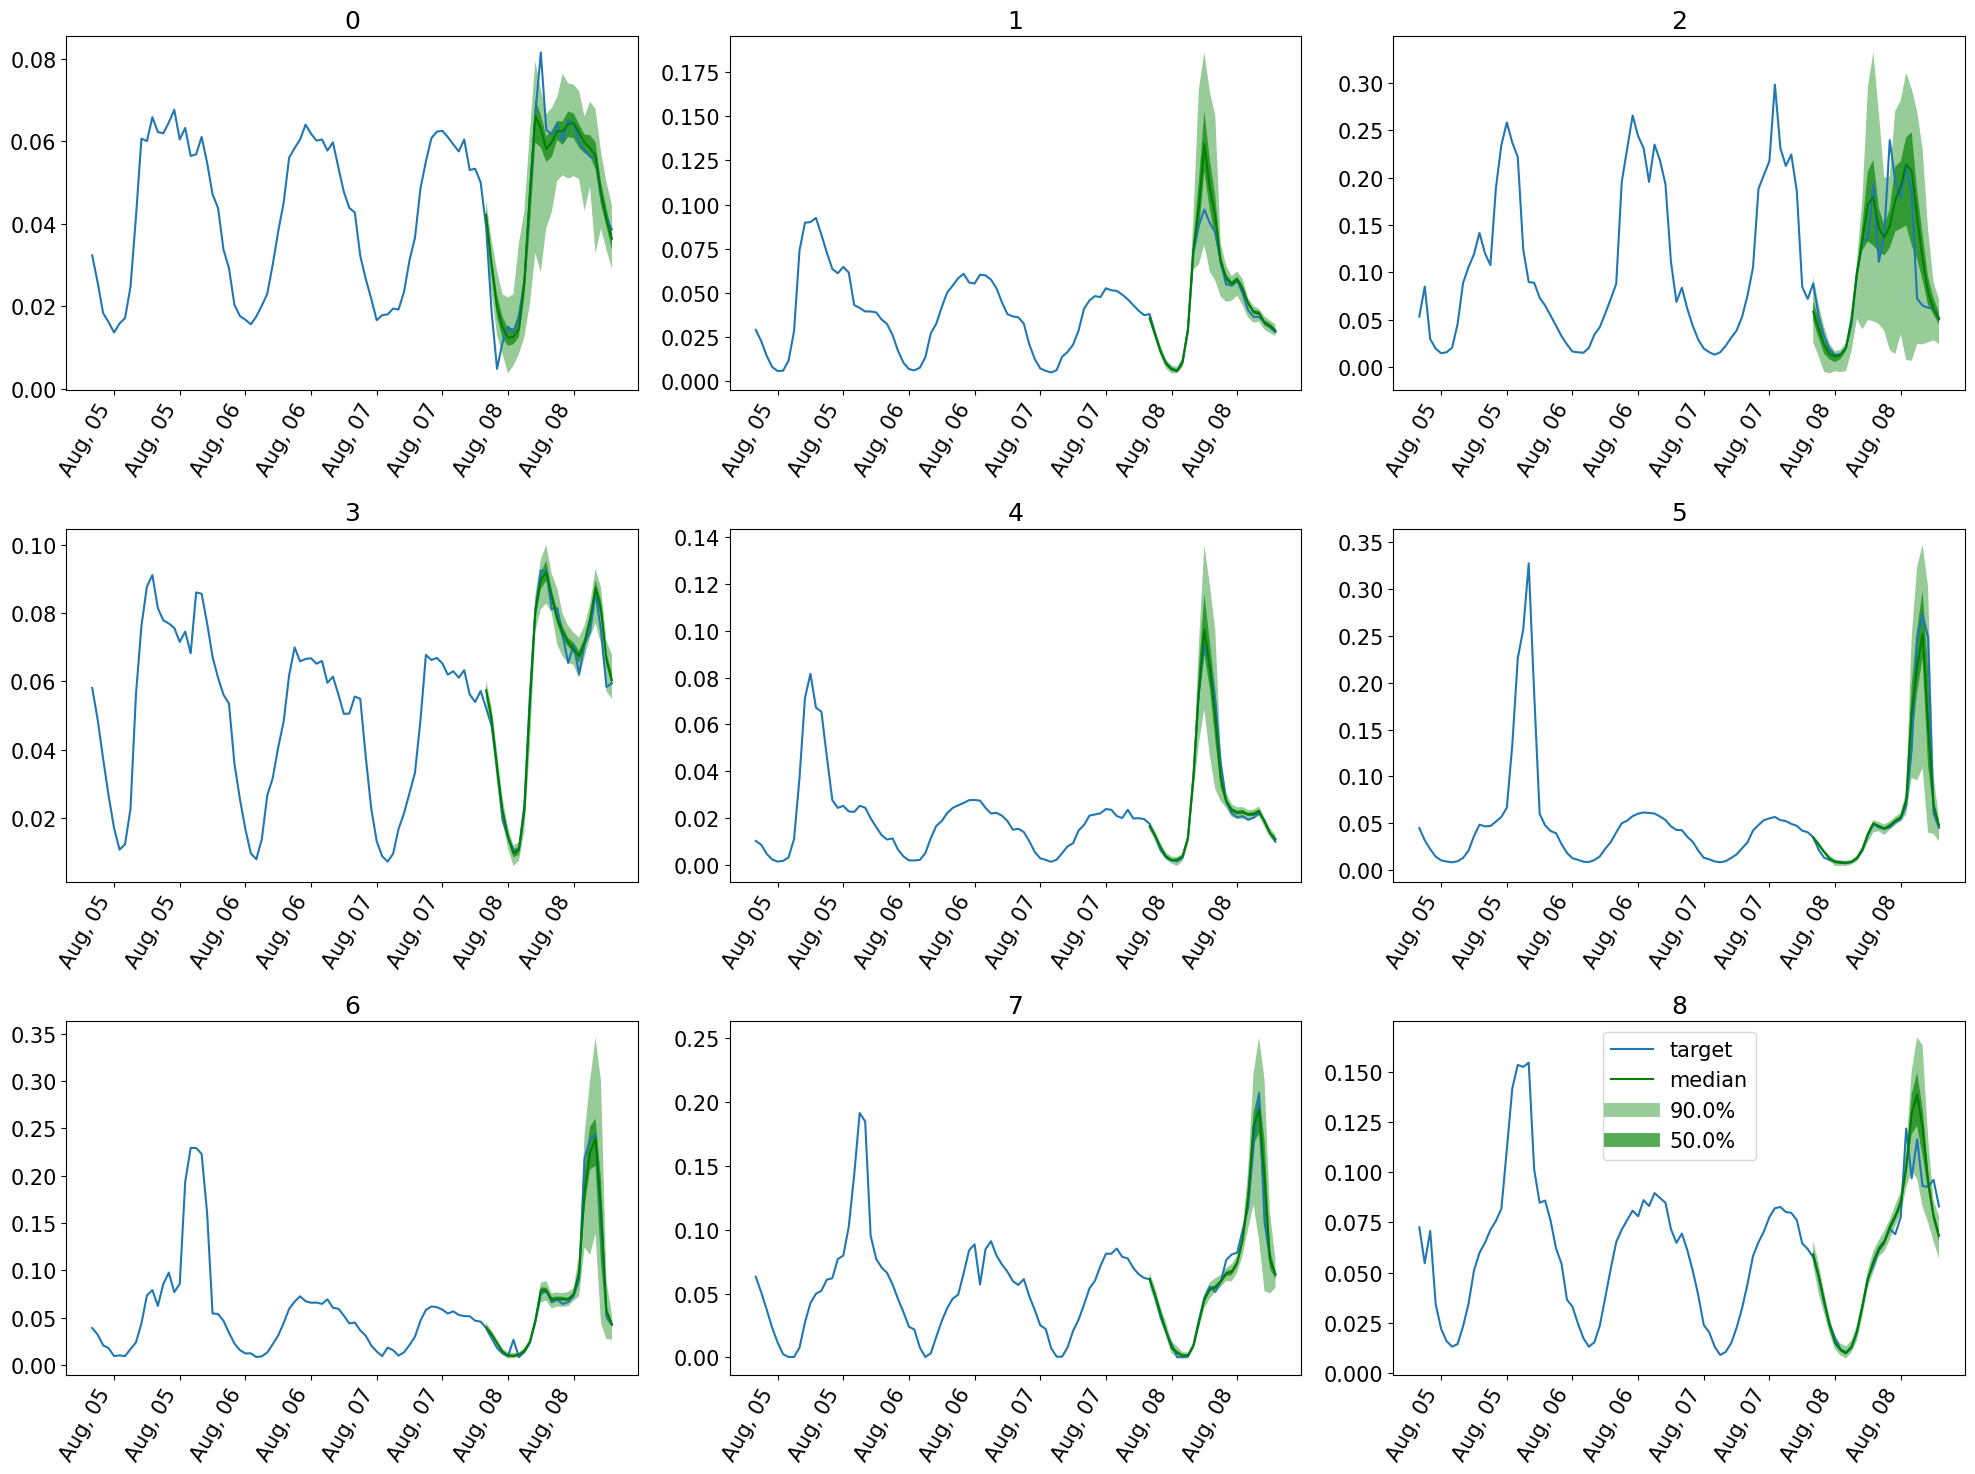

In [14]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [29]:
agg_metrics

{'MSE': 0.0009735079624914573,
 'abs_error': 2557.504844032228,
 'abs_target_sum': 8672.5710073933,
 'abs_target_mean': 0.0598868288545002,
 'seasonal_error': 0.015220711169889631,
 'MASE': 1.3000324385806992,
 'MAPE': 1.2105401288497324,
 'sMAPE': 0.3941314951953486,
 'MSIS': 11.508284072789623,
 'QuantileLoss[0.1]': 1247.7999667831973,
 'Coverage[0.1]': 0.3044207822340073,
 'QuantileLoss[0.2]': 1838.6187099514589,
 'Coverage[0.2]': 0.4167978676389349,
 'QuantileLoss[0.3]': 2217.341031904658,
 'Coverage[0.3]': 0.5013603469229919,
 'QuantileLoss[0.4]': 2449.6894316156395,
 'Coverage[0.4]': 0.5712697491989835,
 'QuantileLoss[0.5]': 2557.504843601957,
 'Coverage[0.5]': 0.6335556844547564,
 'QuantileLoss[0.6]': 2545.3354630095882,
 'Coverage[0.6]': 0.6856700917025744,
 'QuantileLoss[0.7]': 2400.088776300754,
 'Coverage[0.7]': 0.7447933929952493,
 'QuantileLoss[0.8]': 2083.7158349916335,
 'Coverage[0.8]': 0.8087227930615402,
 'QuantileLoss[0.9]': 1500.0963136690668,
 'Coverage[0.9]': 0.886

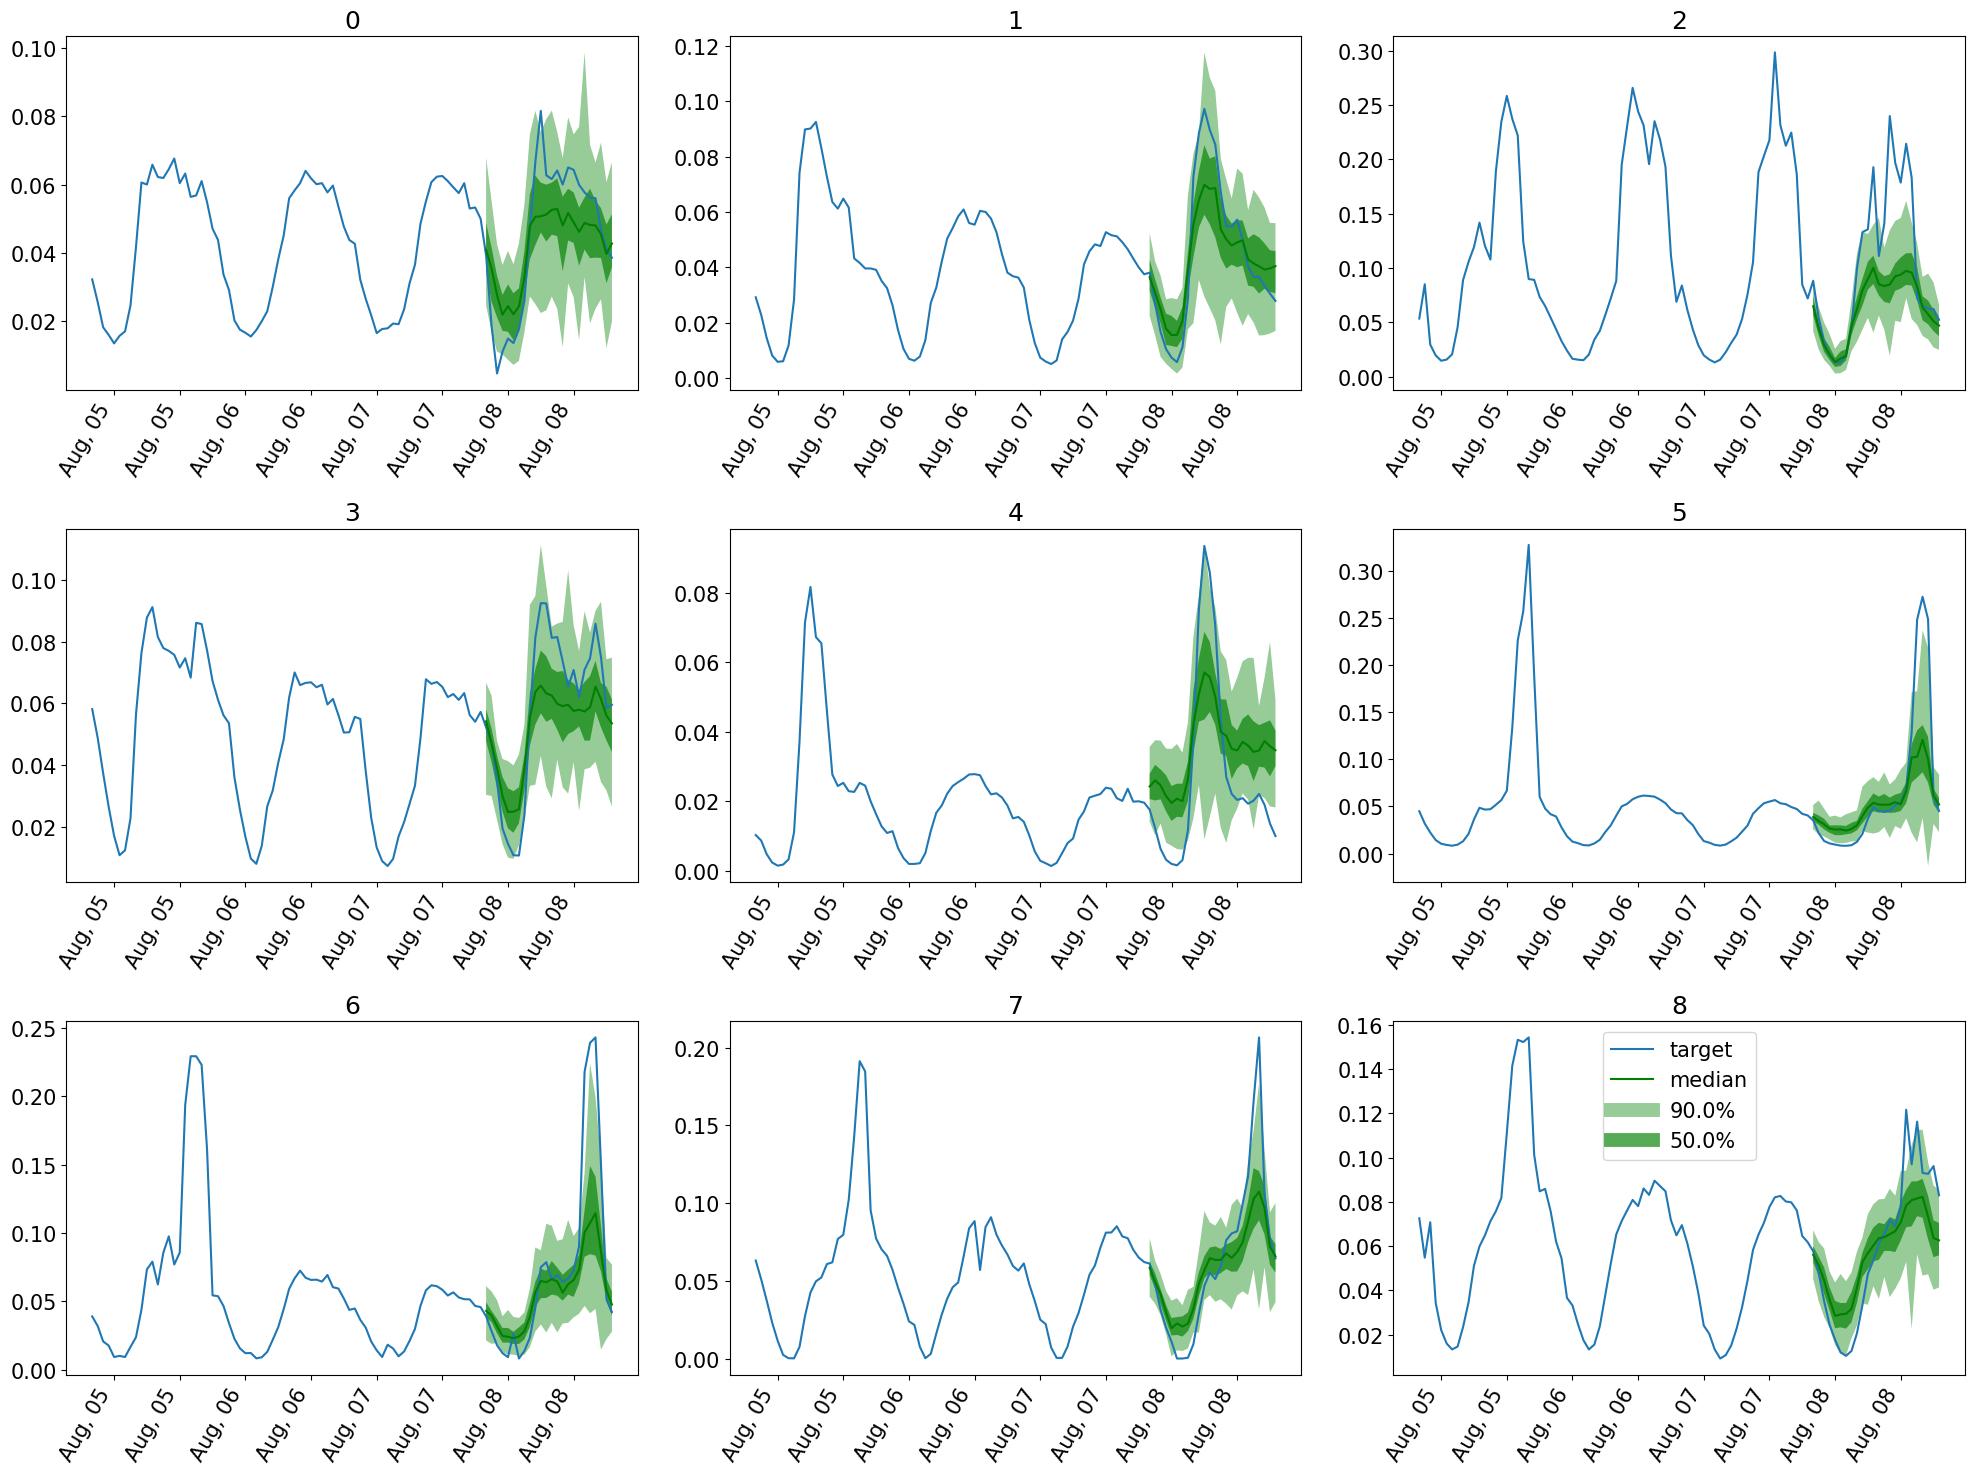

In [28]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()